In [1]:
import cv2
import numpy as np
import os

import datetime
from skimage import io
import os
import random
import matplotlib.pyplot as plt
% matplotlib inline
import glob

UsageError: Line magic function `%` not found.


In [2]:
# # Starts capturing video
# cap = cv2.VideoCapture(0)

# fps = int(cap.get(cv2.CAP_PROP_FPS))

# print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

# while cap.isOpened():
#     ret, frame = cap.read()
#     cv2.imshow('Captured Frame', frame)
#     if cv2.waitKey(1) == ord('q'):
#         break

#     keypress = cv2.waitKey(1) & 0xFF

# cap.release()
# cv2.destroyAllWindows()


In [3]:
#---------------------------------------------
# To segment the region of hand in the image
#---------------------------------------------
def segment(image, threshold=25):
    global bg
    # find the absolute difference between background and current frame
    diff = cv2.absdiff(bg.astype("uint8"), image)

    # threshold the diff image so that we get the foreground
    thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)[1]

    # get the contours in the thresholded image
    (cnts, _) = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # return None, if no contours detected
    if len(cnts) == 0:
        return
    else:
        # based on contour area, get the maximum contour which is the hand
        segmented = max(cnts, key=cv2.contourArea)
        return (thresholded, segmented)

### 2D CNN Model

In [4]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import Adam


# model
model = Sequential()

# first conv layer
# input shape = (img_rows, img_cols, 1)
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100,120, 1))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(6, activation='softmax'))

# model summary
optimiser = Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 118, 32)       320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 118, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 59, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 59, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 57, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 47, 57, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 28, 64)       

### Training the model with the dataset

In [5]:
# Loading the Dataset

DATASET_PATH = '/kaggle/input/hand-gesture-recog-dataset/data'

dataset_path = os.path.join(DATASET_PATH, '*')
import glob
dataset_path = glob.glob(dataset_path)
dataset_path

['/kaggle/input/hand-gesture-recog-dataset/data/five',
 '/kaggle/input/hand-gesture-recog-dataset/data/thumbsdown',
 '/kaggle/input/hand-gesture-recog-dataset/data/fist',
 '/kaggle/input/hand-gesture-recog-dataset/data/blank',
 '/kaggle/input/hand-gesture-recog-dataset/data/ok',
 '/kaggle/input/hand-gesture-recog-dataset/data/thumbsup']

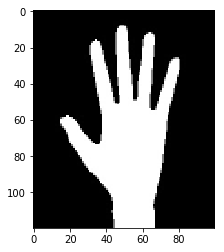

In [6]:
import cv2
image = cv2.imread('/kaggle/input/hand-gesture-recog-dataset/data/five/hand1(1015).jpg')
image = cv2.resize(image,(100, 120))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [7]:
loaded_images = []

list_of_gestures = ['blank', 'ok', 'thumbsup', 'thumbsdown', 'fist', 'five']

for path in range(0, len(dataset_path)):
    dataset_path = "/kaggle/input/hand-gesture-recog-dataset/data/" + str(list_of_gestures[path])
    gesture_path = os.path.join(dataset_path, '*')
    import glob
    gest_path = glob.glob(gesture_path)
    k = 0
    for i in range(0, len(gest_path)):
        if k < 1600:
            image = cv2.imread(gest_path[i])
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray_image = cv2.resize(gray_image,(100, 120))
            loaded_images.append(gray_image)
        k=k+1
print(len(loaded_images))

outputVectors = []
for i in range(1, 1601):
    outputVectors.append([1, 0, 0, 0, 0, 0])

for i in range(1, 1601):
    outputVectors.append([0, 1, 0, 0, 0, 0])

for i in range(1, 1601):
    outputVectors.append([0, 0, 1, 0, 0, 0])
    
for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 1, 0, 0])
    
for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 0, 1, 0])

for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 0, 0, 1])

print(len(outputVectors))

9600
9600


In [8]:
X = np.asarray(loaded_images)
y = np.asarray(outputVectors)
print(X.shape)
print(y.shape)

(9600, 120, 100)
(9600, 6)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
X_train = X_train.reshape(X_train.shape[0], 100, 120, 1)
X_test = X_test.reshape(X_test.shape[0], 100, 120, 1)
print(X_train.shape)
print(X_test.shape)

(7680, 100, 120, 1)
(1920, 100, 120, 1)


In [10]:
# Training the model with data
model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test))

# model.save("hand_gesture_recognition.h5")

Train on 7680 samples, validate on 1920 samples
Epoch 1/10
7680/7680 [==============================] - 9s 1ms/step - loss: 2.8744 - categorical_accuracy: 0.7292 - val_loss: 0.7971 - val_categorical_accuracy: 0.7724
Epoch 2/10
7680/7680 [==============================] - 4s 570us/step - loss: 0.3010 - categorical_accuracy: 0.8936 - val_loss: 0.0491 - val_categorical_accuracy: 0.9812
Epoch 3/10
7680/7680 [==============================] - 4s 577us/step - loss: 0.2151 - categorical_accuracy: 0.9254 - val_loss: 0.0545 - val_categorical_accuracy: 0.9792
Epoch 4/10
7680/7680 [==============================] - 4s 570us/step - loss: 0.1890 - categorical_accuracy: 0.9348 - val_loss: 0.0341 - val_categorical_accuracy: 0.9870
Epoch 5/10
7680/7680 [==============================] - 4s 573us/step - loss: 0.1594 - categorical_accuracy: 0.9380 - val_loss: 0.1052 - val_categorical_accuracy: 0.9536
Epoch 6/10
7680/7680 [==============================] - 4s 572us/step - loss: 0.1288 - categorical_accur

In [11]:
[loss, acc] = model.evaluate(X_test,y_test,verbose=1)
print("Accuracy: " + str(acc))

1920/1920 [==============================] - 0s 238us/step
Accuracy: 0.9927083253860474
